# CS6340 Project 2: Predict Real Estate Sale Prices

## By Jack Schlederer

TODO

In [812]:
import dateutil.parser
import numpy
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

from math import sqrt

import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Loading the data

Let's start by loading in the Sacramento real estate transaction dataset.

In [813]:
# housing_df = pd.read_csv('/content/drive/MyDrive/cs6340_lab2/Sacramentorealestatetransactions.csv')
housing_df = pd.read_csv('D:\Development\ml_project_2\Sacramentorealestatetransactions.csv')
housing_df.head()

,street,city,zip,state,beds,baths,sq__ft,type,sale_date,price,latitude,longitude
0,3526 HIGH ST,SACRAMENTO,95838,CA,2,1,836,Residential,Wed May 21 00:00:00 EDT 2008,59222,38.631913,-121.434879
1,51 OMAHA CT,SACRAMENTO,95823,CA,3,1,1167,Residential,Wed May 21 00:00:00 EDT 2008,68212,38.478902,-121.431028
2,2796 BRANCH ST,SACRAMENTO,95815,CA,2,1,796,Residential,Wed May 21 00:00:00 EDT 2008,68880,38.618305,-121.443839
3,2805 JANETTE WAY,SACRAMENTO,95815,CA,2,1,852,Residential,Wed May 21 00:00:00 EDT 2008,69307,38.616835,-121.439146
4,6001 MCMAHON DR,SACRAMENTO,95824,CA,2,1,797,Residential,Wed May 21 00:00:00 EDT 2008,81900,38.519470,-121.435768


In [814]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 985 entries, 0 to 984
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   street     985 non-null    object 
 1   city       985 non-null    object 
 2   zip        985 non-null    int64  
 3   state      985 non-null    object 
 4   beds       985 non-null    int64  
 5   baths      985 non-null    int64  
 6   sq__ft     985 non-null    int64  
 7   type       985 non-null    object 
 8   sale_date  985 non-null    object 
 9   price      985 non-null    int64  
 10  latitude   985 non-null    float64
 11  longitude  985 non-null    float64
dtypes: float64(2), int64(5), object(5)
memory usage: 92.5+ KB


## Massaging the data

Let's set some of the fields we know to be categorical as Pandas type `category`.

In [815]:
housing_df['city'] = housing_df['city'].astype('category')
housing_df['zip'] = housing_df['zip'].astype('category')
housing_df['state'] = housing_df['state'].astype('category')
housing_df['type'] = housing_df['type'].astype('category')
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 985 entries, 0 to 984
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   street     985 non-null    object  
 1   city       985 non-null    category
 2   zip        985 non-null    category
 3   state      985 non-null    category
 4   beds       985 non-null    int64   
 5   baths      985 non-null    int64   
 6   sq__ft     985 non-null    int64   
 7   type       985 non-null    category
 8   sale_date  985 non-null    object  
 9   price      985 non-null    int64   
 10  latitude   985 non-null    float64 
 11  longitude  985 non-null    float64 
dtypes: category(4), float64(2), int64(4), object(2)
memory usage: 69.8+ KB


Further massaging the data for better usage in a ML model, let's one-hot encode the city, ZIP code, and property type using the `get_dummies` method.

In [816]:
one_hot_df_list = list()

for column in ['city', 'zip', 'type']:
  _oh_encoded = pd.get_dummies(housing_df[column], prefix=column)
  one_hot_df_list.append(_oh_encoded)

experiment_dataframe = pd.concat(one_hot_df_list, axis=1)
housing_df = pd.concat([housing_df, experiment_dataframe], axis=1)

## "Binning" transaction prices

To allow us to train-test split in a _stratified_ manner, we'll separate the transactions by price into a small number of ranges (bins). This way, we can split the training set and the testing set proportionally to each bin.

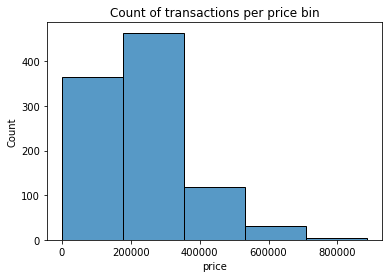

In [817]:
bin_count = 5

bins = numpy.histogram_bin_edges(housing_df['price'], bins=bin_count)
sns.histplot(housing_df['price'], bins=bins)

plt.title('Count of transactions per price bin')
plt.show()

We can just add the price bin number to the "master" dataframe we've been working with.

In [818]:
bin_array = numpy.digitize(housing_df['price'], bins)
housing_df['price_bin'] = bin_array
housing_df

,street,city,zip,state,beds,baths,sq__ft,type,sale_date,price,latitude,longitude,city_ANTELOPE,city_AUBURN,city_CAMERON PARK,city_CARMICHAEL,city_CITRUS HEIGHTS,city_COOL,city_DIAMOND SPRINGS,city_EL DORADO,city_EL DORADO HILLS,city_ELK GROVE,city_ELVERTA,city_FAIR OAKS,city_FOLSOM,city_FORESTHILL,city_GALT,city_GARDEN VALLEY,city_GOLD RIVER,city_GRANITE BAY,city_GREENWOOD,city_LINCOLN,city_LOOMIS,city_MATHER,city_MEADOW VISTA,city_NORTH HIGHLANDS,city_ORANGEVALE,city_PENRYN,city_PLACERVILLE,city_POLLOCK PINES,city_RANCHO CORDOVA,city_RANCHO MURIETA,city_RIO LINDA,city_ROCKLIN,city_ROSEVILLE,city_SACRAMENTO,city_SHINGLE SPRINGS,city_SLOUGHHOUSE,city_WALNUT GROVE,city_WEST SACRAMENTO,city_WILTON,zip_95603,zip_95608,zip_95610,zip_95614,zip_95619,zip_95621,zip_95623,zip_95624,zip_95626,zip_95628,zip_95630,zip_95631,zip_95632,zip_95633,zip_95635,zip_95648,zip_95650,zip_95655,zip_95660,zip_95661,zip_95662,zip_95663,zip_95667,zip_95670,zip_95673,zip_95677,zip_95678,zip_95682,zip_95683,zip_95690,zip_95691,zip_95693,zip_95722,zip_95726,zip_95742,zip_95746,zip_95747,zip_95757,zip_95758,zip_95762,zip_95765,zip_95811,zip_95814,zip_95815,zip_95816,zip_95817,zip_95818,zip_95819,zip_95820,zip_95821,zip_95822,zip_95823,zip_95824,zip_95825,zip_95826,zip_95827,zip_95828,zip_95829,zip_95831,zip_95832,zip_95833,zip_95834,zip_95835,zip_95838,zip_95841,zip_95842,zip_95843,zip_95864,type_Condo,type_Multi-Family,type_Residential,type_Unkown,price_bin
0,3526 HIGH ST,SACRAMENTO,95838,CA,2,1,836,Residential,Wed May 21 00:00:00 EDT 2008,59222,38.631913,-121.434879,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1
1,51 OMAHA CT,SACRAMENTO,95823,CA,3,1,1167,Residential,Wed May 21 00:00:00 EDT 2008,68212,38.478902,-121.431028,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
2,2796 BRANCH ST,SACRAMENTO,95815,CA,2,1,796,Residential,Wed May 21 00:00:00 EDT 2008,68880,38.618305,-121.443839,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
3,2805 JANETTE WAY,SACRAMENTO,95815,CA,2,1,852,Residential,Wed May 21 00:00:00 EDT 2008,69307,38.616835,-121.439146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
4,6001 MCMAHON DR,SACRAMENTO,95824,CA,2,1,797,Residential,Wed May 21 00:00:00 EDT 2008,81900,38.519470,-121.435768,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
980,9169 GARLINGTON CT,SACRAMENTO,95829,CA,4,3,2280,Residential,Thu May 15 00:00:00 EDT 2008,232425,38.457679,-121.359620,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2
981,6932 RUSK

## Train-test splitting

Now that we have something to stratify by, let's use scikit-learn's train-test split function to split out 25% of our data for testing. The other 75% will be used to train the ML models.

In [819]:
housing_df['price_bin'] = housing_df['price_bin'].where(housing_df['price_bin'] != (bin_count + 1), other=bin_count)
training_df, testing_df = train_test_split(housing_df, test_size=0.25, train_size=0.75, stratify=housing_df['price_bin'])

Verifying size of each...

In [820]:
training_df.shape

(738, 124)

In [821]:
testing_df.shape

(247, 124)

Looks good!

## Preparing the data for ML models

Most machine learning models perform better when features with floating-point or integer values are "scaled" such that their mean is 0. This helps bring all the numeric features onto the same playing field, so no small number of features dominates the calculative structure at the core of the model, whether that's a regression function, a decision tree, or otherwise.

Here, we'll use a pipeline and scikit-learn's (henceforth referred to as sklearn per it's Python `import` statement) `StandardScaler` to scale the numeric features.

The categorical features are already one-hot encoded, but we could have also created a pipeline to perform that operation with sklearn functions, then combine the pipelines into _another_ pipeline for concision.

In [822]:
numeric_columns = ['beds', 'baths', 'sq__ft', 'latitude', 'longitude']
scaled_columns = ['beds_scaled', 'baths_scaled', 'sq__ft_scaled', 'latitude_scaled', 'longitude_scaled']

numeric_pipeline = make_pipeline(StandardScaler())

full_pipeline = ColumnTransformer([
    ("numeric", numeric_pipeline, numeric_columns)
])

# We could make a pipeline here with a one-hot encoder for the categorical columns but that's already been done

# Fit and apply the StandardScaler with the training data, then apply it to the testing data
training_df[scaled_columns] = full_pipeline.fit_transform(training_df)
testing_df[scaled_columns] = full_pipeline.transform(testing_df)

# Get the price columns
training_prices = training_df['price']
testing_prices = testing_df['price']

# Drop the columns we don't want to use in the regression model
columns_to_drop = ['street', 'city', 'zip', 'state', 'beds', 'baths', 'sq__ft', 'type', 'sale_date', 'price', 'latitude', 'longitude', 'price_bin']
training_df = training_df.drop(columns=columns_to_drop)
testing_df = testing_df.drop(columns=columns_to_drop)

Let's take a quick look at the now preprocessed data which will be fed into the predictor pipeline.

In [823]:
testing_df.head()

,city_ANTELOPE,city_AUBURN,city_CAMERON PARK,city_CARMICHAEL,city_CITRUS HEIGHTS,city_COOL,city_DIAMOND SPRINGS,city_EL DORADO,city_EL DORADO HILLS,city_ELK GROVE,city_ELVERTA,city_FAIR OAKS,city_FOLSOM,city_FORESTHILL,city_GALT,city_GARDEN VALLEY,city_GOLD RIVER,city_GRANITE BAY,city_GREENWOOD,city_LINCOLN,city_LOOMIS,city_MATHER,city_MEADOW VISTA,city_NORTH HIGHLANDS,city_ORANGEVALE,city_PENRYN,city_PLACERVILLE,city_POLLOCK PINES,city_RANCHO CORDOVA,city_RANCHO MURIETA,city_RIO LINDA,city_ROCKLIN,city_ROSEVILLE,city_SACRAMENTO,city_SHINGLE SPRINGS,city_SLOUGHHOUSE,city_WALNUT GROVE,city_WEST SACRAMENTO,city_WILTON,zip_95603,zip_95608,zip_95610,zip_95614,zip_95619,zip_95621,zip_95623,zip_95624,zip_95626,zip_95628,zip_95630,zip_95631,zip_95632,zip_95633,zip_95635,zip_95648,zip_95650,zip_95655,zip_95660,zip_95661,zip_95662,zip_95663,zip_95667,zip_95670,zip_95673,zip_95677,zip_95678,zip_95682,zip_95683,zip_95690,zip_95691,zip_95693,zip_95722,zip_95726,zip_95742,zip_95746,zip_95747,zip_95757,zip_95758,zip_95762,zip_95765,zip_95811,zip_95814,zip_95815,zip_95816,zip_95817,zip_95818,zip_95819,zip_95820,zip_95821,zip_95822,zip_95823,zip_95824,zip_95825,zip_95826,zip_95827,zip_95828,zip_95829,zip_95831,zip_95832,zip_95833,zip_95834,zip_95835,zip_95838,zip_95841,zip_95842,zip_95843,zip_95864,type_Condo,type_Multi-Family,type_Residential,type_Unkown,beds_scaled,baths_scaled,sq__ft_scaled,latitude_scaled,longitude_scaled
791,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.819179,1.342956,1.025887,1.127983,0.371863
324,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-2.265280,-2.020511,-1.553630,1.088807,0.363478
742,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.048064,0.221800,0.578087,0.112968,-0.133661
393,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0.048064,0.221800,0.043991,0.242977,-0.618068
965,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.048064,0.221800,0.099966,-1.278989,-0.539720


## Predicting the prices

We'll use an `SGDRegressor` class from sklearn to predict the prices for our testing dataset. But first, we need to _train_ it with the training dataset.

In [824]:
reg = SGDRegressor()
reg.fit(training_df, training_prices)

SGDRegressor()

Easy, right? Now comes the fun part: predicting the prices. We'll construct a new dataframe with the actual prices and the predicted prices spit out by the trained SGDRegressor.

In [825]:
testing_prices_actual_predict = pd.DataFrame({'actual_price': testing_prices, 'predicted_price': reg.predict(testing_df)})
testing_prices_actual_predict.head()

,actual_price,predicted_price
791,315000,344694.716468
324,500500,189346.242132
742,250000,240915.491896
393,155435,172776.581281
965,220000,239716.457343


These seem to be _somewhat_ in the ballpark (don't yell at me if there are outliers in the `head`, we'll take care of them later), so let's find the mean error.

In [826]:
actual_prices = testing_prices_actual_predict['actual_price']
predicted_prices = testing_prices_actual_predict['predicted_price']
error_pass_1 = sqrt(mean_squared_error(actual_prices, predicted_prices))
error_pass_1

95195.31618288787

This means that the average prediction is off by about $100k. Let's visualize the results. On the X-axis is the actual price of the transactions, with the predictions on the Y-axis. I've gone ahead and added a `Y=X` line too in red for reference. The closer our datapoints are to that, the more accurate the model is.

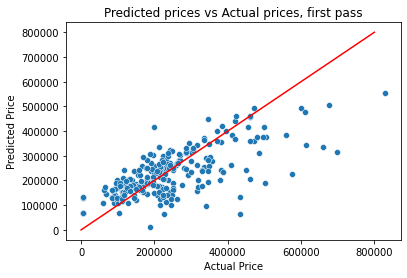

In [827]:
sns.scatterplot(x=actual_prices, y=predicted_prices)

X_plot = numpy.linspace(0, 8e5, 10)
Y_plot = X_plot
plt.plot(X_plot, Y_plot, color='red')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted prices vs Actual prices, first pass")
plt.show()

An alternative way to represent this is to plot the error as a function of the price predictions. I've also added a `Y=0` line in red for reference. Similarly, the closer the data points are to it, the more accurate the model is. Since the error used here is _signed_, transactions below the line had their price _over_ predicted, while the ones above it had their price _under_ predicted.

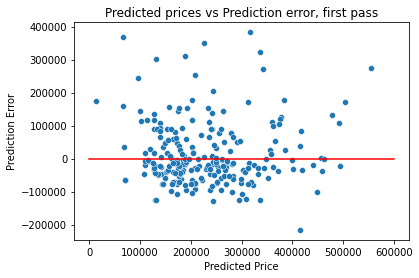

In [828]:
testing_prices_actual_predict['error'] = testing_prices_actual_predict['actual_price'] - testing_prices_actual_predict['predicted_price']

prediction_errors = testing_prices_actual_predict['error']

sns.scatterplot(x=predicted_prices, y=prediction_errors)

X_plot = numpy.linspace(0, 6e5, 10)
Y_plot = X_plot * 0
plt.plot(X_plot, Y_plot, color='red')
plt.xlabel("Predicted Price")
plt.ylabel("Prediction Error")
plt.title("Predicted prices vs Prediction error, first pass")
plt.show()

## Removing Outliers

Let's remove the outliers that meet one or more of these conditions:
* Square-footage of 0
* Property type of "Unkown" [sic]
* Properties with very high or low prices

Removing the outliers is a good and cheap way to improve the accuracy of the model.

In [829]:
# Square-footage of 0
housing_df = housing_df[housing_df.sq__ft != 0]

# Property type of "Unkown"
housing_df = housing_df[housing_df.type != "Unkown"]

# Remove "very high" prices. Let's remove anything higher than the 99th price percentile
housing_df = housing_df[housing_df.price < housing_df['price'].quantile(.99)]

# Remove "very low" prices. Let's remove anything lower than the 1st price percentile
housing_df = housing_df[housing_df.price > housing_df['price'].quantile(.01)]

Let's take a look at the size of the new dataframe.

In [830]:
housing_df.shape

(796, 124)

Looks good! Now with the outliers removed, we'll have to redo our expiermental setup. That is, we'll have to re-bin, re-train-test split, re-preprocess, re-train the model, and re-predict. For the sake of brevity, since it's mostly copy-pasted from above, I'm going to do this all in a single cell with little annotation.

In [831]:
bin_count = 5

bins = numpy.histogram_bin_edges(housing_df['price'], bins=bin_count)

bin_array = numpy.digitize(housing_df['price'], bins)
housing_df['price_bin'] = bin_array

housing_df['price_bin'] = housing_df['price_bin'].where(housing_df['price_bin'] != (bin_count + 1), other=bin_count)
training_df, testing_df = train_test_split(housing_df, test_size=0.25, train_size=0.75, stratify=housing_df['price_bin'])

numeric_columns = ['beds', 'baths', 'sq__ft', 'latitude', 'longitude']
scaled_columns = ['beds_scaled', 'baths_scaled', 'sq__ft_scaled', 'latitude_scaled', 'longitude_scaled']

numeric_pipeline = make_pipeline(StandardScaler())

full_pipeline = ColumnTransformer([
    ("numeric", numeric_pipeline, numeric_columns)
])

training_df[scaled_columns] = full_pipeline.fit_transform(training_df)
testing_df[scaled_columns] = full_pipeline.transform(testing_df)

training_prices = training_df['price']
testing_prices = testing_df['price']

columns_to_drop = ['street', 'city', 'zip', 'state', 'beds', 'baths', 'sq__ft', 'type', 'sale_date', 'price', 'latitude', 'longitude', 'price_bin']
training_df = training_df.drop(columns=columns_to_drop)
testing_df = testing_df.drop(columns=columns_to_drop)

reg = SGDRegressor()
reg.fit(training_df, training_prices)

testing_prices_actual_predict = pd.DataFrame({'actual_price': testing_prices, 'predicted_price': reg.predict(testing_df)})
testing_prices_actual_predict.head()

,actual_price,predicted_price
45,164000,124223.846572
682,190000,218385.793714
55,178760,226229.369276
787,311518,338886.848535
142,395000,479240.282742


Great! Let's recalculate our error now.

In [832]:
actual_prices = testing_prices_actual_predict['actual_price']
predicted_prices = testing_prices_actual_predict['predicted_price']
error_pass_2 = sqrt(mean_squared_error(actual_prices, predicted_prices))
error_pass_2

62990.63700429777

Wow! That's a considerable decrease in error. By leveraging the power of _mathematics_ and _computers_, we can determine just how much better.

In [833]:
percent_change = (error_pass_1 - error_pass_2) / error_pass_1 * 100
print("The model, after removing outliers, improved by {:.2f}%".format(percent_change))

The model, after removing outliers, improved by 33.83%


Let's take another look at the graphs. Remember, the closer the points are to the red line, the better.

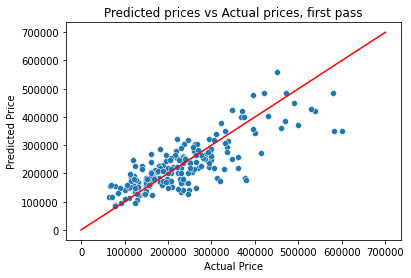

In [834]:
sns.scatterplot(x=actual_prices, y=predicted_prices)

X_plot = numpy.linspace(0, 7e5, 10)
Y_plot = X_plot
plt.plot(X_plot, Y_plot, color='red')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted prices vs Actual prices, first pass")
plt.show()

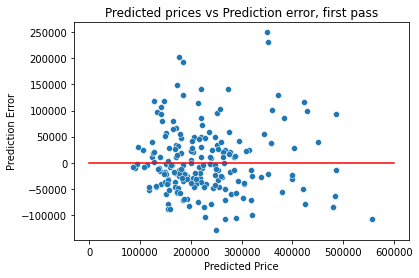

In [835]:
testing_prices_actual_predict['error'] = testing_prices_actual_predict['actual_price'] - testing_prices_actual_predict['predicted_price']

prediction_errors = testing_prices_actual_predict['error']

sns.scatterplot(x=predicted_prices, y=prediction_errors)

X_plot = numpy.linspace(0, 6e5, 10)
Y_plot = X_plot * 0
plt.plot(X_plot, Y_plot, color='red')
plt.xlabel("Predicted Price")
plt.ylabel("Prediction Error")
plt.title("Predicted prices vs Prediction error, first pass")
plt.show()

A quick visual inspection shows that both plots have fewer points farther away from the red reference functions (that's good!).

## Reformulating the problem and model types

Up until now, we've been predicting the _price_ of the transactions, but there may be better variables to predict, which could lead to a more accurate model. For the next experiment, we'll try out predicting price per sq. ft., then multiplying the output by the square-footage, which will give us the price of the house.

In [836]:
housing_df['price_per_sqft'] = housing_df['price'] / housing_df['sq__ft']
housing_df = housing_df.drop(columns='price_bin', errors='ignore')

bin_count = 8
bins = numpy.histogram_bin_edges(housing_df['price_per_sqft'], bins=bin_count)
bin_array = numpy.digitize(housing_df['price_per_sqft'], bins)
housing_df['price_per_sqft_bin'] = bin_array
housing_df['price_per_sqft_bin'] = housing_df['price_per_sqft_bin'].where(housing_df['price_per_sqft_bin'] != (bin_count + 1), other=bin_count)

# Need to "cheat" the bins a little bit, since otherwise 8 bins with this dataset leaves a bin with only one item, which the train-test splitter doesn't like
housing_df['price_per_sqft_bin'] = housing_df['price_per_sqft_bin'].where(housing_df['price_per_sqft_bin'] != 8, other=6)

housing_df['price_per_sqft_bin'].value_counts()
training_df, testing_df = train_test_split(housing_df, test_size=0.25, train_size=0.75, stratify=housing_df['price_per_sqft_bin'])

numeric_columns = ['beds', 'baths', 'sq__ft', 'latitude', 'longitude']
scaled_columns = ['beds_scaled', 'baths_scaled', 'sq__ft_scaled', 'latitude_scaled', 'longitude_scaled']

numeric_pipeline = make_pipeline(StandardScaler())

full_pipeline = ColumnTransformer([
    ("numeric", numeric_pipeline, numeric_columns)
])

training_df[scaled_columns] = full_pipeline.fit_transform(training_df)
testing_df[scaled_columns] = full_pipeline.transform(testing_df)

training_prices_per_sqft = training_df['price_per_sqft']
testing_prices_per_sqft = testing_df['price_per_sqft']
testing_sqft = testing_df['sq__ft']
testing_prices = testing_df['price']

columns_to_drop = ['street', 'city', 'zip', 'state', 'beds', 'baths', 'sq__ft', 'type', 'sale_date', 'price', 'latitude', 'longitude', 'price_per_sqft', 'price_per_sqft_bin']
training_df = training_df.drop(columns=columns_to_drop)
testing_df = testing_df.drop(columns=columns_to_drop)

reg = SGDRegressor()
reg.fit(training_df, training_prices_per_sqft)

testing_prices_per_sqft_actual_predict = pd.DataFrame({'actual_price_per_sqft': testing_prices_per_sqft, 'predicted_price_per_sqft': reg.predict(testing_df)})
testing_prices_per_sqft_actual_predict.head()

,actual_price_per_sqft,predicted_price_per_sqft
197,112.500000,135.464275
957,165.885103,146.722433
272,197.250345,179.261903
167,99.567100,113.337915
504,157.772622,117.270652


The outputs look generally pretty good per a visual spot-check on the `head()`. Now, let's transform these values back to the price and calculate the error.

In [837]:
testing_prices_per_sqft_actual_predict['sq__ft'] = testing_sqft
testing_prices_per_sqft_actual_predict['actual_price'] = testing_prices
testing_prices_per_sqft_actual_predict['predicted_price'] = testing_prices_per_sqft_actual_predict['predicted_price_per_sqft'] * testing_prices_per_sqft_actual_predict['sq__ft']
testing_prices_per_sqft_actual_predict.head()

,actual_price_per_sqft,predicted_price_per_sqft,sq__ft,actual_price,predicted_price
197,112.500000,135.464275,1320,148500,178812.843459
957,165.885103,146.722433,1262,209347,185163.710844
272,197.250345,179.261903,1450,286013,259929.758905
167,99.567100,113.337915,924,92000,104724.233006
504,157.772622,117.270652,2155,340000,252718.254631


In [838]:
actual_prices = testing_prices_per_sqft_actual_predict['actual_price']
predicted_prices = testing_prices_per_sqft_actual_predict['predicted_price']
error_pass_3 = sqrt(mean_squared_error(actual_prices, predicted_prices))
error_pass_3

62702.15935067908

Once again, let's see how this differs from the first and second experiments.

In [839]:
percent_change = (error_pass_2 - error_pass_3) / error_pass_2 * 100
print("The model, now trained to predict price/sq-ft, improved by {:.2f}% against the second experiment".format(percent_change))

percent_change = (error_pass_1 - error_pass_3) / error_pass_1 * 100
print("It also improved by {:.2f}% against the first experiment".format(percent_change))

The model, now trained to predict price/sq-ft, improved by 0.46% against the second experiment
It also improved by 34.13% against the first experiment


Not bad! This error is similar to that of the experiment where the raw price was used as the output with outliers removed. To round out this experiment, let's take a look at the graphs.

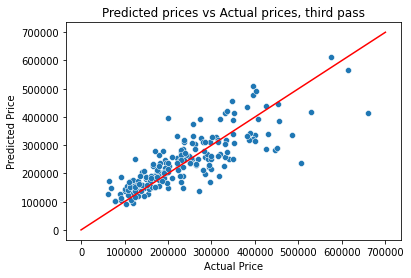

In [840]:
sns.scatterplot(x=actual_prices, y=predicted_prices)

X_plot = numpy.linspace(0, 7e5, 10)
Y_plot = X_plot
plt.plot(X_plot, Y_plot, color='red')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted prices vs Actual prices, third pass")
plt.show()

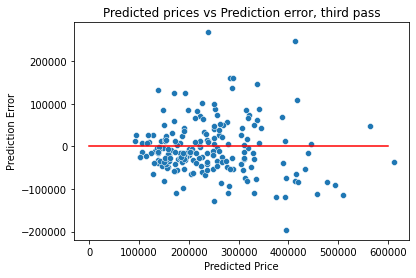

In [841]:
testing_prices_per_sqft_actual_predict['error'] = testing_prices_per_sqft_actual_predict['actual_price'] - testing_prices_per_sqft_actual_predict['predicted_price']

prediction_errors = testing_prices_per_sqft_actual_predict['error']

sns.scatterplot(x=predicted_prices, y=prediction_errors)

X_plot = numpy.linspace(0, 6e5, 10)
Y_plot = X_plot * 0
plt.plot(X_plot, Y_plot, color='red')
plt.xlabel("Predicted Price")
plt.ylabel("Prediction Error")
plt.title("Predicted prices vs Prediction error, third pass")
plt.show()

## Feature engineering

For the next part of the project, we're going to play around with a few ways to potentially increase the accuracy of our model. We can engineer new features out our dataset to add more "juice" to train the model with. The first one I'd like to try is day of the year. Conventional wisdom leads me to believe that folks are less likely to sell the house during the winter and more likely during the summer, which could cause demand fluctuations, and therefore price fluctuations throughout the year. This will entail writing a quick function to calculate the day of the year given a `datetime`, and adding it to the numerical column pipeline to be scaled, then retraining and repredicting.

In [842]:
housing_df = pd.read_csv('D:\Development\ml_project_2\Sacramentorealestatetransactions.csv')

def convert_to_date(x):
    return dateutil.parser.parse(x['sale_date'], ignoretz=True)

sale_dates = housing_df.apply(convert_to_date, axis='columns')
housing_df['sale_date'] = sale_dates

def convert_to_day_of_year(x):
    return x['sale_date'].timetuple().tm_yday

housing_df['day_of_year'] = housing_df.apply(convert_to_day_of_year, axis='columns')
housing_df['day_of_year'].value_counts()

140    268
137    264
141    177
142    158
136    118
Name: day_of_year, dtype: int64

Since there are only 5 values total, I'm thinking it would be better to one-hot encode this field rather than treat it as numeric and scale it. During the writing of this notebook, I had the opportunity to try out sklearn's `KBinsDiscretizer` and `OneHotEncoder` classes in a sandbox environment, so I'm going to build up the preprocessing pipeline with those classes instead of the `pandas` and `numpy` functions used earlier, and use it to preprocess this new feature set, after removing outliers first.

In [843]:
# Square-footage of 0
housing_df = housing_df[housing_df.sq__ft != 0]

# Property type of "Unkown"
housing_df = housing_df[housing_df.type != "Unkown"]

# Remove "very high" prices. Let's remove anything higher than the 99th price percentile
housing_df = housing_df[housing_df.price < housing_df['price'].quantile(.99)]

# Remove "very low" prices. Let's remove anything lower than the 1st price percentile
housing_df = housing_df[housing_df.price > housing_df['price'].quantile(.01)]

Now onto creating price bins...

In [844]:
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')

price_bin_transformer = ColumnTransformer([
    ("kbins", discretizer, ['price'])
])

price_bins = price_bin_transformer.fit_transform(housing_df)
pd.DataFrame(price_bins).value_counts()

1.0    328
0.0    314
2.0    106
3.0     36
4.0     12
dtype: int64

In [845]:
housing_df.head()

,street,city,zip,state,beds,baths,sq__ft,type,sale_date,price,latitude,longitude,day_of_year
1,51 OMAHA CT,SACRAMENTO,95823,CA,3,1,1167,Residential,2008-05-21,68212,38.478902,-121.431028,142
2,2796 BRANCH ST,SACRAMENTO,95815,CA,2,1,796,Residential,2008-05-21,68880,38.618305,-121.443839,142
3,2805 JANETTE WAY,SACRAMENTO,95815,CA,2,1,852,Residential,2008-05-21,69307,38.616835,-121.439146,142
4,6001 MCMAHON DR,SACRAMENTO,95824,CA,2,1,797,Residential,2008-05-21,81900,38.519470,-121.435768,142
5,5828 PEPPERMILL CT,SACRAMENTO,95841,CA,3,1,1122,Condo,2008-05-21,89921,38.662595,-121.327813,142


Let's get just the prices, for train-test splitting purposes.

In [846]:
housing_prices = housing_df['price']
housing_prices.head()

1    68212
2    68880
3    69307
4    81900
5    89921
Name: price, dtype: int64

We can now build up our preprocessing pipeline. By default, the ColumnTransformer will drop any column not transformed by it. That's good in our case, because if the transformer isn't touching it (like address and price), we don't need it.

In [847]:
numeric_columns = ['beds', 'baths', 'sq__ft', 'latitude', 'longitude']
categorical_columns = ['city', 'zip', 'type', 'day_of_year']
scaled_columns = ['beds_scaled', 'baths_scaled', 'sq__ft_scaled', 'latitude_scaled', 'longitude_scaled']

categorical_pipeline = make_pipeline(
    OneHotEncoder()
)

numeric_pipeline = make_pipeline(
    StandardScaler()
)

full_pipeline = ColumnTransformer([
    ("categorical", categorical_pipeline, categorical_columns),
    ("numeric", numeric_pipeline, numeric_columns)
])

Now, let's preprocess the master dataframe to get the master features matrix.

In [848]:
features_matrix = full_pipeline.fit_transform(housing_df)
features_matrix.shape

(796, 114)

We can train-test split the features matrix using the price bins from earlier.

In [849]:
training_df, testing_df, training_prices, testing_prices = train_test_split(features_matrix, housing_prices, test_size=0.25, stratify=price_bins)

And finally, we'll train an `SGDRegressor` model and predict the prices for the testing dataset.

In [850]:
model = SGDRegressor()
model.fit(training_df, training_prices)
predicted_prices = model.predict(testing_df)
prices_compare = pd.DataFrame({'actual_price': testing_prices, 'predicted_price': predicted_prices})
prices_compare.head()

,actual_price,predicted_price
512,360552,262148.915652
760,276500,276055.658125
274,292000,277568.672063
975,228000,212586.560694
87,242638,313694.771958


These appear to be somewhat reasonable, so how about an error calculation?

In [851]:
error_pass_4 = sqrt(mean_squared_error(testing_prices, predicted_prices))
error_pass_4

60934.85480515514

Not bad, but did it improve over the previous models? Let's find out.

In [852]:
percent_change = (error_pass_3 - error_pass_4) / error_pass_3 * 100
print("The model, now trained with the sale-day-of-year feature, improved by {:.2f}% against the third experiment".format(percent_change))

percent_change = (error_pass_2 - error_pass_4) / error_pass_2 * 100
print("It also improved by {:.2f}% against the second experiment".format(percent_change))

percent_change = (error_pass_1 - error_pass_4) / error_pass_1 * 100
print("It also improved by {:.2f}% against the first experiment".format(percent_change))

The model, now trained with the sale-day-of-year feature, improved by 2.82% against the third experiment
It also improved by 3.26% against the second experiment
It also improved by 35.99% against the first experiment


Seems like we're making incremental improvements to the model (generally speaking, as these errors will change on every run of the notebook).